## Лабороторна робота 4
## Абрамова Марія

In [1]:
import pandas as pd
import random
import tensorflow as tf 
from matplotlib import pyplot as plt

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split

2021-11-25 16:39:02.516684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-25 16:39:02.516762: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Get a text dataset

In [2]:
siameseData = pd.read_csv("siamese_nn.csv")
emotionData = pd.read_csv("emotion_recognition.csv",sep=";")
covidData = pd.read_csv("coranavirus_disease.csv",sep=";")
covidData["target"] = 2
emotionData["target"] = 0

In [3]:
train_df = pd.concat([emotionData,covidData, siameseData], ignore_index=True )
train_shuffle=train_df.sample(frac=1,random_state=9) 
train_shuffle.head(10)

,text,target
39,In order to demonstrate the high effectivennes...,0
38,"In this experimental work, we have used Multiv...",0
183,Hao has constructed the ensemble predictor of ...,2
13,. After the last convolutional layer we divide...,0
90,Speech is the main and direct means of transmi...,0
165,Region-wise this distribution depicts total de...,2
44,. It contains 535 utterances spoken by 10 acto...,0
4,The main advantage of DL is the fact that it r...,0
57,The researchers are still debating for what fe...,0
149,"In addition, the introduced method learns to g...",2


In [4]:
train_shuffle.target.value_counts()

0    100
2    100
1    100
Name: target, dtype: int64

In [5]:
train_sentences, test_sentences, train_labels,test_labels = train_test_split(
    train_shuffle['text'].to_numpy(),
    train_shuffle['target'].to_numpy(),
    test_size=0.1, 
    random_state=40
)

In [6]:
max_sq_len = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
text_vectorizer = TextVectorization(max_tokens=10000,  #number of word in vocabulary
                                    standardize="lower_and_strip_punctuation", 
                                    split ="whitespace",
                                    output_mode="int",
                                    output_sequence_length=max_sq_len,
                                    pad_to_max_tokens=True)

2021-11-25 16:39:19.137529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-25 16:39:19.215224: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-25 16:39:19.215281: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mariia-HP-ProBook-430-G2): /proc/driver/nvidia/version does not exist
2021-11-25 16:39:19.215699: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
text_vectorizer.adapt(train_sentences)

2021-11-25 16:39:19.486955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [8]:
embedding = Embedding(
                        input_dim=10000, 
                        output_dim=128, 
                        input_length=max_sq_len, 
                        name = 'embeding_1'
)

## Helper Function to evaluate: accuracy, precision, recall, f1-score

In [9]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results
  

In [10]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")


In [11]:
def plot_history(history): 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Model 0: Baseline 

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0= Pipeline([ 
    ("tfidf",TfidfVectorizer()), 
    ("clf", MultinomialNB())
])
model_0.fit(train_sentences,train_labels)
model_0_preds =model_0.predict(test_sentences)
model_0_results = calculate_results(test_labels,model_0_preds)

## Model 2: LSTM

In [13]:
from tensorflow.keras import layers



inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation="relu")(x) 
outputs = layers.Dense(3, activation="softmax")(x)

model_2 = tf.keras.Model(inputs,outputs,name="model_2_LSTM")


In [14]:
model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [15]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 24)                0         
_________________________________________________________________
embeding_1 (Embedding)       (None, 24, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,333,763
Trainable params: 1,333,763
Non-trainable params: 0
____________________________________________

In [16]:
model_2_history = model_2.fit(train_sentences,train_labels, epochs=5,batch_size=5, validation_data=(test_sentences,test_labels))

Epoch 1/5
54/54 [==============================] - 6s 56ms/step - loss: 1.0938 - accuracy: 0.4000 - val_loss: 1.0775 - val_accuracy: 0.4333
Epoch 2/5
54/54 [==============================] - 2s 43ms/step - loss: 0.6377 - accuracy: 0.6926 - val_loss: 0.5781 - val_accuracy: 0.7333
Epoch 3/5
54/54 [==============================] - 2s 35ms/step - loss: 0.2274 - accuracy: 0.9296 - val_loss: 0.2484 - val_accuracy: 0.9333
Epoch 4/5
54/54 [==============================] - 2s 40ms/step - loss: 0.0725 - accuracy: 0.9852 - val_loss: 0.5530 - val_accuracy: 0.8000
Epoch 5/5
54/54 [==============================] - 2s 40ms/step - loss: 0.0084 - accuracy: 0.9963 - val_loss: 0.5182 - val_accuracy: 0.8333


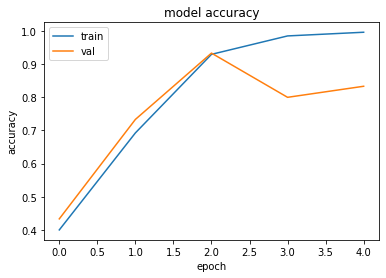

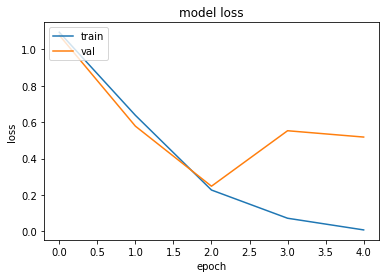

In [17]:
plot_history(model_2_history)

In [18]:
model_2.evaluate(test_sentences, test_labels)

1/1 [==============================] - 1s 948ms/step - loss: 0.5182 - accuracy: 0.8333


[0.5182180404663086, 0.8333333134651184]

In [19]:
# Make predictions 
model_2_pred_probs = model_2.predict(test_sentences)

In [20]:
model_2_preds = tf.squeeze(tf.argmax(model_2_pred_probs, axis = 1))
model_2_preds

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([0, 2, 1, 0, 2, 2, 1, 0, 2, 0, 2, 2, 0, 0, 2, 1, 0, 2, 0, 2, 0, 2,
       0, 0, 1, 2, 0, 1, 1, 1])>

In [21]:
model_2_results = calculate_results(test_labels,model_2_preds)
model_2_results

{'accuracy': 83.33333333333334,
 'precision': 0.8537878787878788,
 'recall': 0.8333333333333334,
 'f1': 0.8314663256606991}

In [22]:
compare_baseline_to_new_results(model_0_results, model_2_results)

Baseline accuracy: 96.67, New accuracy: 83.33, Difference: -13.33
Baseline precision: 0.97, New precision: 0.85, Difference: -0.12
Baseline recall: 0.97, New recall: 0.83, Difference: -0.13
Baseline f1: 0.97, New f1: 0.83, Difference: -0.13


## Model 3: GRU

In [23]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(3, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [24]:
model_3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [25]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 24)                0         
_________________________________________________________________
embeding_1 (Embedding)       (None, 24, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 1,321,603
Trainable params: 1,321,603
Non-trainable params: 0
_____________________________________________

In [26]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentences, test_labels),
                              )

Epoch 1/5
9/9 [==============================] - 3s 100ms/step - loss: 1.0907 - accuracy: 0.4815 - val_loss: 1.0790 - val_accuracy: 0.5667
Epoch 2/5
9/9 [==============================] - 0s 31ms/step - loss: 1.0507 - accuracy: 0.6667 - val_loss: 1.0347 - val_accuracy: 0.6000
Epoch 3/5
9/9 [==============================] - 0s 43ms/step - loss: 0.9542 - accuracy: 0.7519 - val_loss: 0.9343 - val_accuracy: 0.6333
Epoch 4/5
9/9 [==============================] - 0s 38ms/step - loss: 0.6662 - accuracy: 0.8815 - val_loss: 0.6163 - val_accuracy: 0.8000
Epoch 5/5
9/9 [==============================] - 0s 38ms/step - loss: 0.1780 - accuracy: 0.9889 - val_loss: 0.4533 - val_accuracy: 0.8333


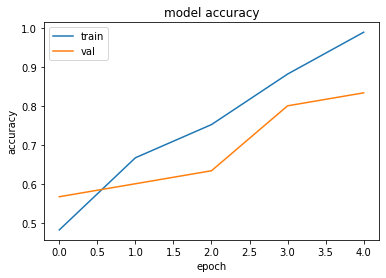

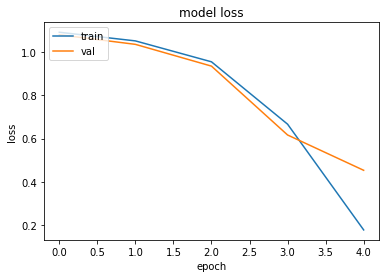

In [27]:
plot_history(model_3_history)

In [28]:
model_3_pred_probs = model_3.predict(test_sentences)

In [29]:
model_3_preds = tf.squeeze(tf.argmax(model_3_pred_probs, axis = 1))
model_3_preds

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([2, 2, 1, 1, 2, 2, 1, 0, 2, 0, 2, 2, 0, 0, 2, 1, 0, 2, 0, 2, 0, 2,
       0, 0, 1, 2, 0, 1, 1, 1])>

In [30]:
model_3_results = calculate_results(y_true = test_labels, y_pred = model_3_preds)
model_3_results 

{'accuracy': 83.33333333333334,
 'precision': 0.8516666666666667,
 'recall': 0.8333333333333334,
 'f1': 0.8328042328042329}

In [31]:
compare_baseline_to_new_results(model_0_results, model_3_results)

Baseline accuracy: 96.67, New accuracy: 83.33, Difference: -13.33
Baseline precision: 0.97, New precision: 0.85, Difference: -0.12
Baseline recall: 0.97, New recall: 0.83, Difference: -0.13
Baseline f1: 0.97, New f1: 0.83, Difference: -0.13


## Model 4: Bidirectonal RNN model (LSTM)

In [32]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(3, activation="softmax")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional_LSTM")

In [33]:
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
model_4.summary()

Model: "model_4_Bidirectional_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 24)                0         
_________________________________________________________________
embeding_1 (Embedding)       (None, 24, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 1,379,203
Trainable params: 1,379,203
Non-trainable params: 0
_________________________________________________________________


In [35]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentences, test_labels),
                              )

Epoch 1/5
9/9 [==============================] - 5s 170ms/step - loss: 1.0532 - accuracy: 0.6556 - val_loss: 1.0094 - val_accuracy: 0.6667
Epoch 2/5
9/9 [==============================] - 0s 52ms/step - loss: 0.7894 - accuracy: 0.9889 - val_loss: 0.7420 - val_accuracy: 0.7667
Epoch 3/5
9/9 [==============================] - 1s 71ms/step - loss: 0.2442 - accuracy: 1.0000 - val_loss: 0.3044 - val_accuracy: 0.9333
Epoch 4/5
9/9 [==============================] - 1s 54ms/step - loss: 0.0293 - accuracy: 0.9963 - val_loss: 0.3037 - val_accuracy: 0.9333
Epoch 5/5
9/9 [==============================] - 1s 72ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.3121 - val_accuracy: 0.9333


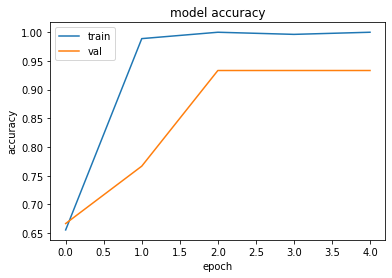

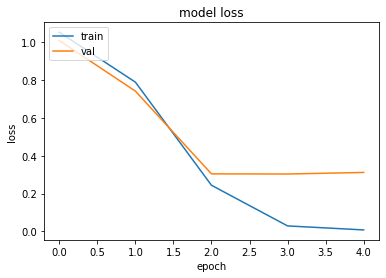

In [36]:
plot_history(model_4_history)

In [37]:
model_4_pred_probs = model_4.predict(test_sentences)
model_4_preds = tf.squeeze(tf.argmax(model_4_pred_probs, axis = 1))
model_4_preds

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 1, 0, 2, 1, 2, 1, 0,
       0, 0, 1, 2, 0, 1, 1, 1])>

In [38]:
model_4_results = calculate_results(y_true = test_labels, y_pred = model_4_preds)
model_4_results 

{'accuracy': 93.33333333333333,
 'precision': 0.9435897435897436,
 'recall': 0.9333333333333333,
 'f1': 0.9319444444444444}

In [39]:
compare_baseline_to_new_results(model_0_results, model_4_results)

Baseline accuracy: 96.67, New accuracy: 93.33, Difference: -3.33
Baseline precision: 0.97, New precision: 0.94, Difference: -0.03
Baseline recall: 0.97, New recall: 0.93, Difference: -0.03
Baseline f1: 0.97, New f1: 0.93, Difference: -0.03


In [40]:
compare_baseline_to_new_results(model_2_results, model_4_results)

Baseline accuracy: 83.33, New accuracy: 93.33, Difference: 10.00
Baseline precision: 0.85, New precision: 0.94, Difference: 0.09
Baseline recall: 0.83, New recall: 0.93, Difference: 0.10
Baseline f1: 0.83, New f1: 0.93, Difference: 0.10


## Model 5: Bidirectonal RNN model (GRU)

In [41]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.GRU(64))(x) 
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Bidirectional_GRU")

In [42]:
model_5.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5.summary()               

Model: "model_5_Bidirectional_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 24)                0         
_________________________________________________________________
embeding_1 (Embedding)       (None, 24, 128)           1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 1,362,947
Trainable params: 1,362,947
Non-trainable params: 0
_______________________________

In [43]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentences, test_labels),
                              )

Epoch 1/5
9/9 [==============================] - 6s 187ms/step - loss: 1.0362 - accuracy: 0.7148 - val_loss: 0.9943 - val_accuracy: 0.7000
Epoch 2/5
9/9 [==============================] - 1s 59ms/step - loss: 0.8272 - accuracy: 0.9519 - val_loss: 0.8228 - val_accuracy: 0.8000
Epoch 3/5
9/9 [==============================] - 1s 68ms/step - loss: 0.4505 - accuracy: 0.9926 - val_loss: 0.5365 - val_accuracy: 0.8000
Epoch 4/5
9/9 [==============================] - 1s 66ms/step - loss: 0.0754 - accuracy: 1.0000 - val_loss: 0.3026 - val_accuracy: 0.8333
Epoch 5/5
9/9 [==============================] - 1s 70ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.3000 - val_accuracy: 0.9667


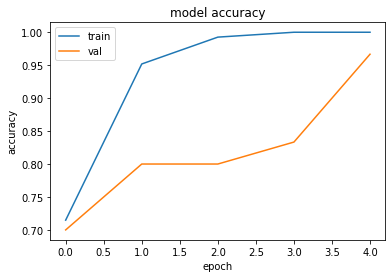

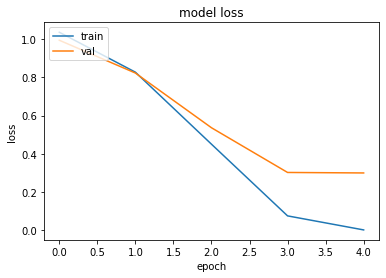

In [44]:
plot_history(model_5_history)

In [45]:
model_5_pred_probs = model_5.predict(test_sentences)
model_5_preds = tf.squeeze(tf.argmax(model_5_pred_probs, axis = 1))
model_5_preds

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 2, 2, 0, 0, 2, 1, 0, 2, 1, 2, 1, 2,
       0, 0, 1, 2, 0, 1, 1, 1])>

In [46]:
model_5_results = calculate_results(y_true = test_labels, y_pred = model_5_preds)
model_5_results 

{'accuracy': 96.66666666666667,
 'precision': 0.9694444444444444,
 'recall': 0.9666666666666667,
 'f1': 0.9664109121909632}

In [47]:
compare_baseline_to_new_results(model_0_results, model_5_results)

Baseline accuracy: 96.67, New accuracy: 96.67, Difference: 0.00
Baseline precision: 0.97, New precision: 0.97, Difference: 0.00
Baseline recall: 0.97, New recall: 0.97, Difference: 0.00
Baseline f1: 0.97, New f1: 0.97, Difference: 0.00


In [48]:
compare_baseline_to_new_results(model_3_results, model_5_results)

Baseline accuracy: 83.33, New accuracy: 96.67, Difference: 13.33
Baseline precision: 0.85, New precision: 0.97, Difference: 0.12
Baseline recall: 0.83, New recall: 0.97, Difference: 0.13
Baseline f1: 0.83, New f1: 0.97, Difference: 0.13


In [49]:
df_compare = pd.DataFrame({'Baseline': model_0_results ,
                             'LSTM' : model_2_results,
                             'GRU': model_3_results,
                             'Bidirectional  LSTM': model_4_results,
                             'Bidirectional  GRU': model_5_results})
df_compare

,Baseline,LSTM,GRU,Bidirectional LSTM,Bidirectional GRU
accuracy,96.666667,83.333333,83.333333,93.333333,96.666667
precision,0.969444,0.853788,0.851667,0.943590,0.969444
recall,0.966667,0.833333,0.833333,0.933333,0.966667
f1,0.966411,0.831466,0.832804,0.931944,0.966411
